In [1]:
# Shared
# 1. Import libraries
import pandas as pd
import numpy as np
import joblib, os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, 
                                precision_score, recall_score, f1_score)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Shared
# 2. Load dataset
df = pd.read_csv("crime_district.csv")

# Remove 'Malaysia' from the state column
df = df[df["state"] != "Malaysia"].copy()

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Inspect
print(df.head())
print(df.info())

     state district category type       date  crimes
112  Johor      All  assault  all 2016-01-01    2820
113  Johor      All  assault  all 2017-01-01    2578
114  Johor      All  assault  all 2018-01-01    1880
115  Johor      All  assault  all 2019-01-01    1923
116  Johor      All  assault  all 2020-01-01    1384
<class 'pandas.core.frame.DataFrame'>
Index: 19040 entries, 112 to 19151
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   state     19040 non-null  object        
 1   district  19040 non-null  object        
 2   category  19040 non-null  object        
 3   type      19040 non-null  object        
 4   date      19040 non-null  datetime64[ns]
 5   crimes    19040 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.0+ MB
None


### Dataset Dictionary

- **state**: The state in Malaysia where the crime is reported (e.g., Selangor, Sabah).  
- **district**: The district within the state.  
- **category**: Broad crime category (e.g., assault, theft).  
- **type**: Specific sub-type of crime (e.g., murder, causing_injury).  
- **date**: Date of record (YYYY-MM-DD).  
- **crimes**: Number of crimes reported (target for regression).  

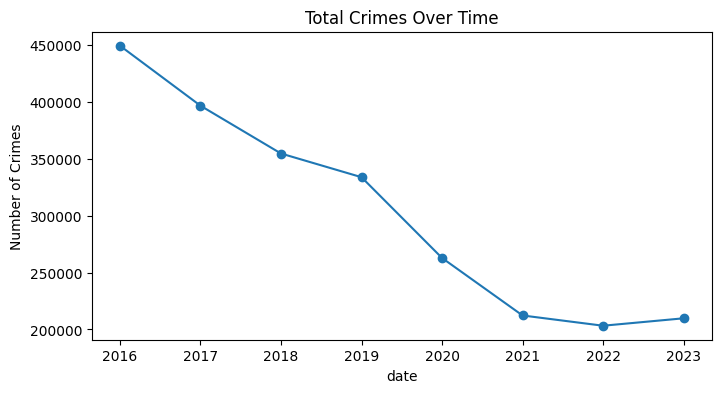

In [3]:
# Crimes over time
df.groupby(df['date'].dt.year)['crimes'].sum().plot(kind="line", marker="o", figsize=(8,4))
plt.title("Total Crimes Over Time")
plt.ylabel("Number of Crimes")
plt.show()

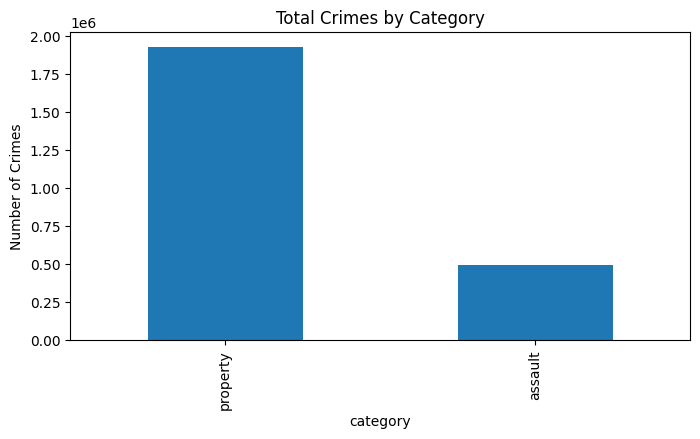

In [4]:
# Top categories
df.groupby("category")['crimes'].sum().sort_values(ascending=False).plot(kind="bar", figsize=(8,4))
plt.title("Total Crimes by Category")
plt.ylabel("Number of Crimes")
plt.show()

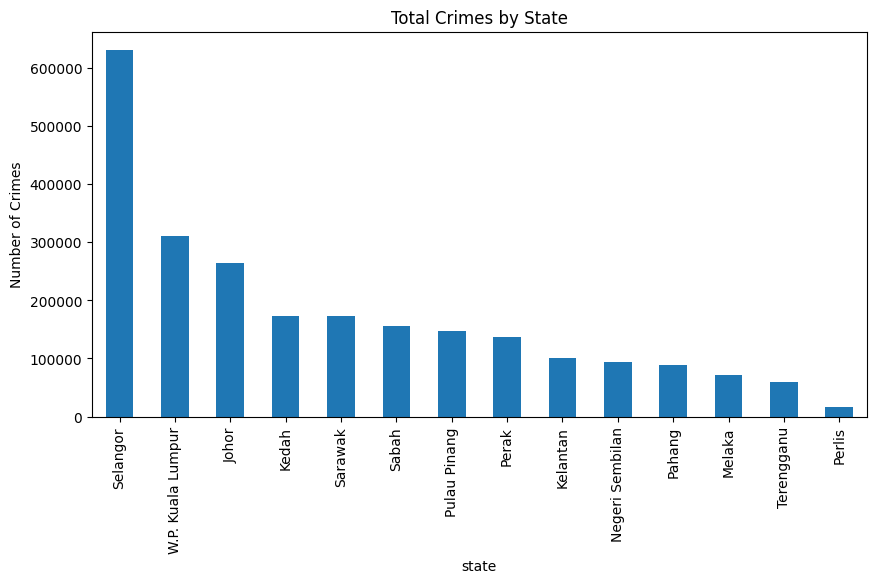

In [5]:
# Crimes by state
df.groupby("state")['crimes'].sum().sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title("Total Crimes by State")
plt.ylabel("Number of Crimes")
plt.show()

In [6]:
# Shared
# 3. Preprocessing
# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Features and targets
X = df.drop(columns=["crimes"])
y_reg = df["crimes"]                        # regression target
y_clf = pd.qcut(y_reg, q=3, labels=[0,1,2]) # classification target: Low, Medium, High

# Column types
categorical = ["state", "district", "category", "type"]
numeric = []  # no continuous numeric features besides crimes counts

# Preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
], remainder="drop")

In [7]:
# Shared
# 4. Train/Test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)

In [8]:
# Combined 
# 5. Regression models
reg_models = {
    # Aina - Linear Regression
    "LinearRegression": LinearRegression(), 
    # Wen Liang - Random Forest
    "RandomForestRegressor": RandomForestRegressor(random_state=42)
}

results_reg = {}
trained_reg_models = {}

for name, model in reg_models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train_r, y_train_r)
    y_pred = pipe.predict(X_test_r)
    
    results_reg[name] = {
        "RMSE": mean_squared_error(y_test_r, y_pred) ** 0.5,
        "R2": r2_score(y_test_r, y_pred)
    }

    trained_reg_models[name] = pipe # save trained pipeline 

pd.DataFrame(results_reg).T

,RMSE,R2
LinearRegression,422.256653,0.346884
RandomForestRegressor,162.853417,0.902853


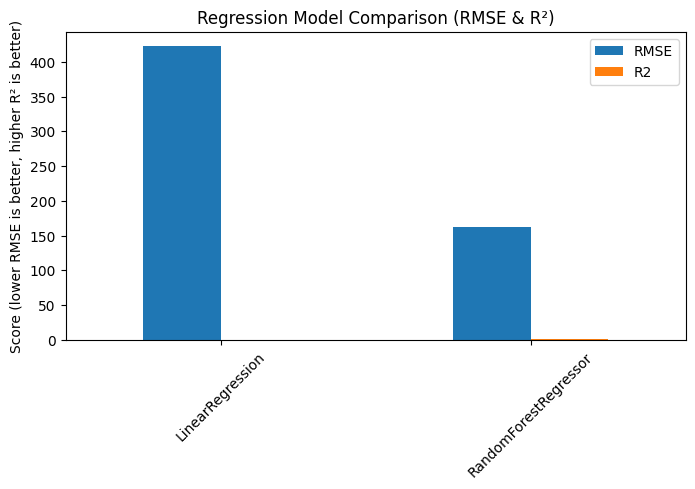

In [9]:
# 5.1 Visualize Regression Results
df_reg = pd.DataFrame(results_reg).T
df_reg.plot(kind="bar", figsize=(8,4))
plt.title("Regression Model Comparison (RMSE & R²)")
plt.ylabel("Score (lower RMSE is better, higher R² is better)")
plt.xticks(rotation=45)
plt.show()


LinearRegression


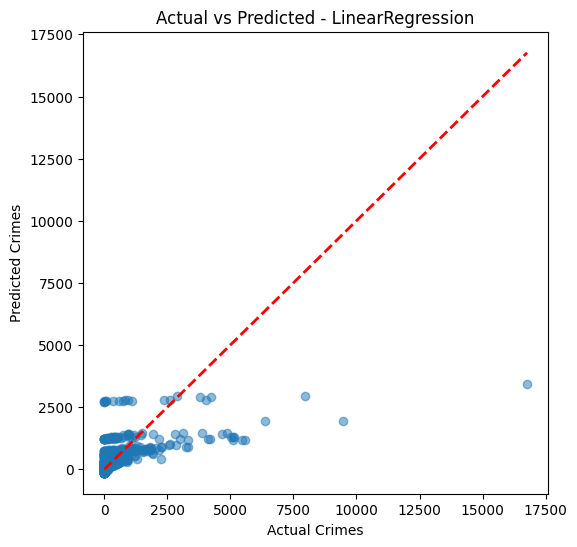

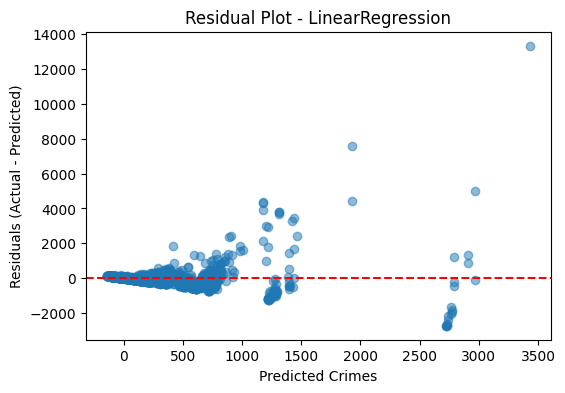


RandomForestRegressor


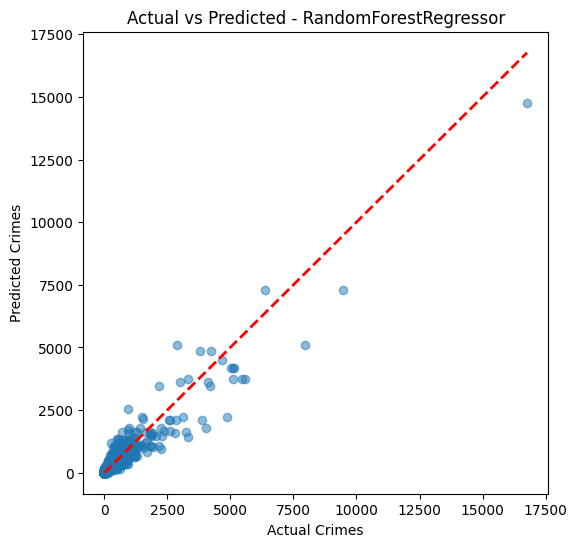

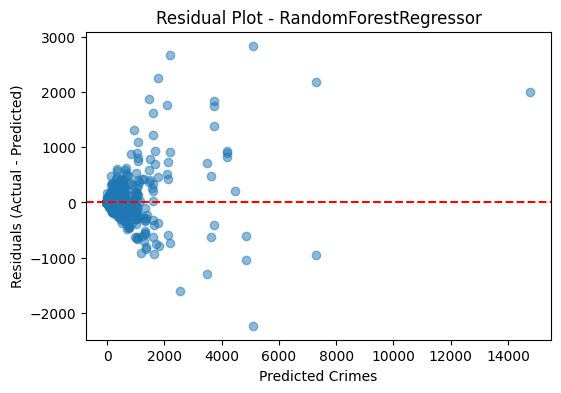

In [20]:
# Regression results visualization for LR and RF
for name, model in reg_models.items():
    print(f"\n{name}")

    # Build pipeline again (with preprocessing)
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train_r, y_train_r)
    y_pred = pipe.predict(X_test_r)

    # Scatter plot: Actual vs Predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_r, y_pred, alpha=0.5)
    plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
    plt.xlabel("Actual Crimes")
    plt.ylabel("Predicted Crimes")
    plt.title(f"Actual vs Predicted - {name}")
    plt.show()

    # Residual plot
    residuals = y_test_r - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Predicted Crimes")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"Residual Plot - {name}")
    plt.show()

In [10]:
# Combined
# 6. Classification models
clf_models = {
    # Wen Liang - Logistic regression + Random Forest
    "LogisticRegression": LogisticRegression(max_iter=500), 
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    # Aina - SVC
    "SVC": SVC(),
}

results_clf = {}
trained_clf_models = {}

for name, model in clf_models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train_c, y_train_c)
    y_pred = pipe.predict(X_test_c)
    
    results_clf[name] = {
        "Accuracy": accuracy_score(y_test_c, y_pred),
        "Precision_macro": precision_score(y_test_c, y_pred, average="macro", zero_division=0),
        "Recall_macro": recall_score(y_test_c, y_pred, average="macro", zero_division=0),
        "F1_macro": f1_score(y_test_c, y_pred, average="macro")
    }

    trained_clf_models[name] = pipe

pd.DataFrame(results_clf).T

,Accuracy,Precision_macro,Recall_macro,F1_macro
LogisticRegression,0.850053,0.849222,0.849131,0.849175
RandomForestClassifier,0.870536,0.870127,0.869782,0.869931
SVC,0.867122,0.866822,0.866370,0.866565


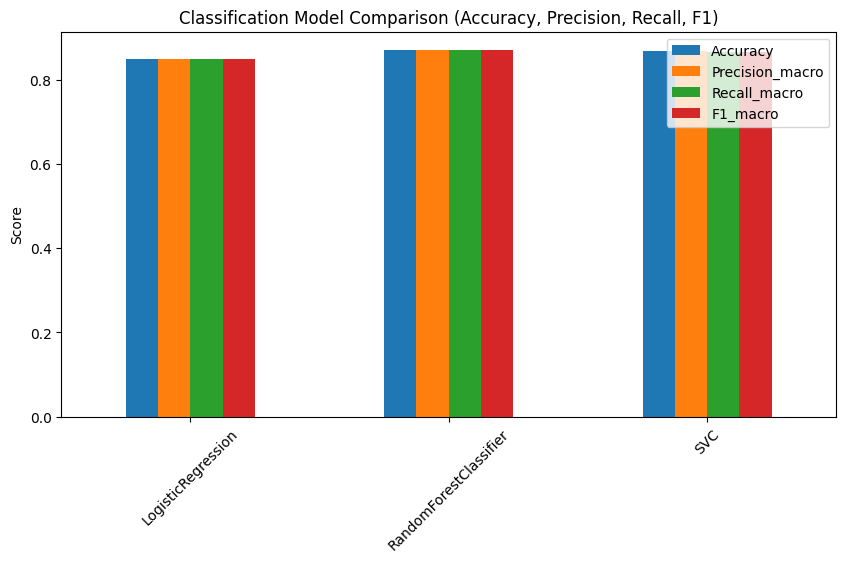

In [11]:
# 6.1 Visualize Classification Results
df_clf = pd.DataFrame(results_clf).T
df_clf.plot(kind="bar", figsize=(10,5))
plt.title("Classification Model Comparison (Accuracy, Precision, Recall, F1)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

In [12]:
# 7. Select best models
best_reg_name = min(results_reg, key=lambda k: results_reg[k]["RMSE"])
best_clf_name = max(results_clf, key=lambda k: results_clf[k]["F1_macro"])

print("Best Regression:", best_reg_name, results_reg[best_reg_name])
print("Best Classification:", best_clf_name, results_clf[best_clf_name])

Best Regression: RandomForestRegressor {'RMSE': 162.8534172731268, 'R2': 0.9028526928147365}
Best Classification: RandomForestClassifier {'Accuracy': 0.8705357142857143, 'Precision_macro': 0.8701265900625031, 'Recall_macro': 0.8697815898345503, 'F1_macro': 0.8699307348205307}



LogisticRegression
Classification Report:
              precision    recall  f1-score   support

         Low       0.89      0.89      0.89      1287
      Medium       0.77      0.77      0.77      1238
        High       0.89      0.88      0.89      1283

    accuracy                           0.85      3808
   macro avg       0.85      0.85      0.85      3808
weighted avg       0.85      0.85      0.85      3808



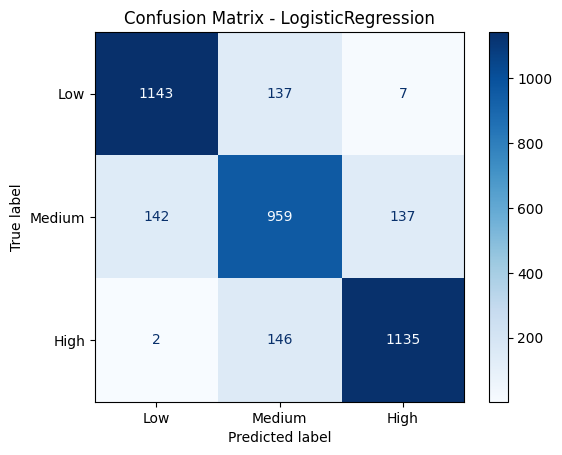


RandomForestClassifier
Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.90      0.90      1287
      Medium       0.80      0.81      0.80      1238
        High       0.91      0.90      0.91      1283

    accuracy                           0.87      3808
   macro avg       0.87      0.87      0.87      3808
weighted avg       0.87      0.87      0.87      3808



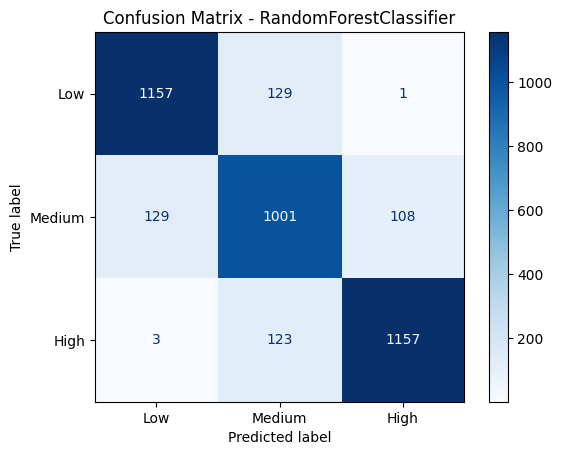


SVC
Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.90      0.90      1287
      Medium       0.79      0.81      0.80      1238
        High       0.91      0.90      0.90      1283

    accuracy                           0.87      3808
   macro avg       0.87      0.87      0.87      3808
weighted avg       0.87      0.87      0.87      3808



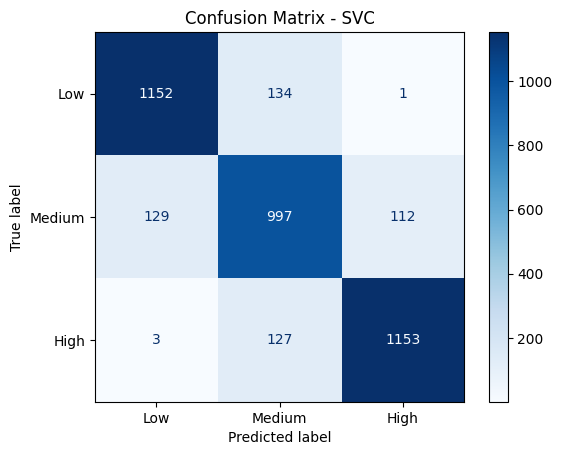

In [18]:
# eavaluate all classification model with confusion matrix + classification report
for name, model in clf_models.items():
    print(f"\n{name}")
    
    # build pipeline to include preprocessing
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train_c, y_train_c)
    y_pred = pipe.predict(X_test_c)

    print("Classification Report:")
    print(classification_report(y_test_c, y_pred, target_names=["Low", "Medium", "High"]))

    cm = confusion_matrix(y_test_c, y_pred, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [14]:
# 8. Retrain best models on full original dataset
best_reg_model = Pipeline([
    ("pre", preprocessor),
    ("model", reg_models[best_reg_name])
])
best_reg_model.fit(X, y_reg)

best_clf_model = Pipeline([
    ("pre", preprocessor),
    ("model", clf_models[best_clf_name])
])
best_clf_model.fit(X, y_clf)

,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
# 9. Save Artifacts
os.makedirs("artifacts", exist_ok=True)

joblib.dump(preprocessor, "artifacts/preprocessor.joblib")

# simplified names
name_map_reg = {"LinearRegression": "LinearRegression", "RandomForestRegressor": "RandomForest"}
name_map_clf = {"LogisticRegression": "LogisticRegression", "RandomForestClassifier": "RandomForest", "SVC": "SVM"}

# Save regression models
for k, model in trained_reg_models.items():
    joblib.dump(model, f"artifacts/regression_{name_map_reg[k]}.joblib")

# Save classification models 
for k, model in trained_clf_models.items():
    joblib.dump(model, f"artifacts/classification_{name_map_clf[k]}.joblib")

summary = {
    "regression": {name_map_reg[k]: v for k, v in results_reg.items()},
    "classification": {name_map_clf[k]: v for k, v in results_clf.items()},
    "best_regression": min(results_reg, key=lambda k: results_reg[k]["RMSE"]),
    "best_classification": max(results_clf, key=lambda k: results_clf[k]["F1_macro"]),
    "classes": ["Low", "Medium", "High"]  # 0, 1, 2
}
joblib.dump(summary, "artifacts/evaluation_summary.joblib")

['artifacts/evaluation_summary.joblib']